In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE 
pd.set_option('display.max_rows',1000)
%matplotlib inline

In [2]:
data = pd.read_pickle('./new_theorem_data.p')

In [3]:
data_raw = data.copy()

In [4]:
data.head().T

ListingNumber,973605,981099,1025766,1003835,1011335
ListingID,973605,981099,1025766,1003835,1011335
DateCreditPulled,2013-10-13 01:50:58,2013-10-15 15:22:06,2013-11-06 23:09:36,2013-11-08 02:25:29,2013-11-11 22:08:44
DateListingStart,2014-01-26 19:00:08.887000,2014-01-10 00:00:16.530000,2014-01-22 01:00:30.420000,2014-01-03 00:00:09.013000,2014-01-10 01:02:19.547000
DateListingCreation,2013-10-13 01:50:56.287000,2013-10-15 15:22:03.990000,2013-11-06 23:09:33.137000,2013-11-08 02:25:27.187000,2013-11-11 22:08:41.660000
EnumListingStatus,7,7,6,7,6
DolLoanAmountRequested,15000,15000,4000,10000,20000
BoolPartialFundingApproved,True,True,True,True,True
CreditGrade,B,B,D,A,B
LenderYield,0.152,0.1485,0.1985,0.1199,0.134
BorrowerRate,0.162,0.1585,0.2085,0.1299,0.144


In [5]:
# Types of data
data.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('float64'), dtype('bool'),
       dtype('O')], dtype=object)

# 1. Data Scheme: One-Hot-Encoding

In [6]:
# Remove Date columns for a start since they are much less relevant ( It is reasonable to assume that the time of the
# year does not have any influence in financial matters, such as, loan origination or cancellation. Hence it is valid 
#to ignore them as a first approximation )
data = data[[col for col in data.columns if col[:4]!='Date']]
# Remove ListingID since it is not predictive
del data['ListingID']

In [7]:
# The remaining non-numeric data
data.columns[data.dtypes == 'object']

Index([u'CreditGrade', u'StrEmploymentStatus', u'StrOccupation', u'StrState',
       u'StrBorrowerCity', u'EnumChannelCode'],
      dtype='object')

In [8]:
# What columns contain null data
col_null = data.columns[data.isnull().any()]
col_null

Index([u'ProsperScore', u'FracDebtToIncomeRatio', u'StrOccupation',
       u'NumMonthsEmployed', u'DolPriorProsperLoansPrincipalBorrowed',
       u'DolPriorProsperLoansPrincipalOutstanding',
       u'DolPriorProsperLoansBalanceOutstanding',
       u'NumPriorProsperLoansCyclesBilled',
       u'NumPriorProsperLoansOnTimePayments',
       u'NumPriorProsperLoansLateCycles', u'NumPriorProsperLoansLatePayments',
       u'DolMaxPriorProsperLoan', u'DolMinPriorProsperLoan',
       u'NumPriorProsperLoansEarliestPayOff', u'NumPriorProsperLoans31dpd',
       u'NumPriorProsperLoans61dpd'],
      dtype='object')

In [9]:
# What's the coverage
data.isnull().mean().sort_values(ascending = False)

NumPriorProsperLoans61dpd                   0.999802
NumPriorProsperLoans31dpd                   0.999501
NumPriorProsperLoansEarliestPayOff          0.972618
DolPriorProsperLoansPrincipalOutstanding    0.935481
NumPriorProsperLoansOnTimePayments          0.935481
DolPriorProsperLoansBalanceOutstanding      0.935481
NumPriorProsperLoansCyclesBilled            0.935481
DolPriorProsperLoansPrincipalBorrowed       0.935481
NumPriorProsperLoansLatePayments            0.935481
NumPriorProsperLoansLateCycles              0.935481
DolMinPriorProsperLoan                      0.935450
DolMaxPriorProsperLoan                      0.935450
StrOccupation                               0.072983
FracDebtToIncomeRatio                       0.061817
NumMonthsEmployed                           0.000071
ProsperScore                                0.000040
BoolIsLender                                0.000000
BoolInGroup                                 0.000000
EnumChannelCode                             0.

In [10]:
# Remove columns/features with more than 90% null data
data = data.loc[:,data.notnull().mean() > 0.1]

In [11]:
# Fill remaining features that contain null appropriately
data['StrOccupation'] = data['StrOccupation'].fillna('Other')
data['ProsperScore'] = data['ProsperScore'].fillna(data['ProsperScore'].mean())
data['NumMonthsEmployed'] = data['NumMonthsEmployed'].fillna(data['NumMonthsEmployed'].mean())
data['FracDebtToIncomeRatio'] = data['FracDebtToIncomeRatio'].fillna(data['FracDebtToIncomeRatio'].mean())

In [12]:
# Any string after '-' or '(' in 'StrOccupation' is removed
data['StrOccupation'] = data['StrOccupation'].apply(lambda x : x.split('-')[0].split('(')[0])
# Make everything in 'StrBorrowerCity' upper-case
data['StrBorrowerCity'] = data['StrBorrowerCity'].apply(lambda x : x.upper())
# Retain only the values with more than 1000 instances in 'StrBorrowerCity'
vc = data['StrBorrowerCity'].value_counts()
data['StrBorrowerCity'] = data['StrBorrowerCity'].apply(lambda x : 'OTHER' if vc[x] < 1000 else x)
# One-hot-encode the categorical features appropriately
data = pd.get_dummies(data, columns=['EnumChannelCode', 'CreditGrade', 'StrEmploymentStatus', 'StrState','StrBorrowerCity','StrOccupation'  ])

In [13]:
#Seperate Target('y') and Features('X')
y = data['EnumListingStatus']==6                                                                                    
del data['EnumListingStatus']
X = data

## 1.1 Logistic Regression

### 1.1.1 K-fold Cross Validation using the inverse of regularisation parameter (C) under Logistic Regression Classifier

In [14]:
C = [10000,100, 1, 0.01,0.0001] 
cv_score = []
for c in C:
    lr = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(lr,X,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

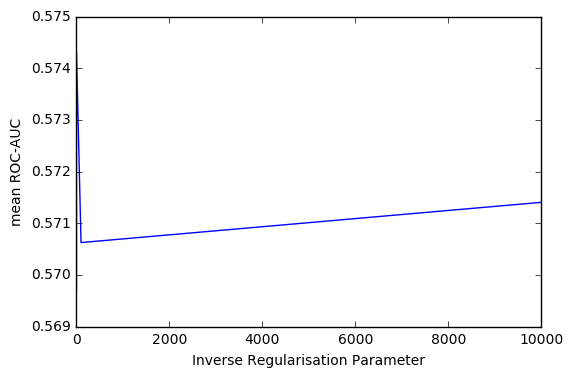

In [15]:
plt.plot(C,cv_score) 
plt.ylabel('mean ROC-AUC')
plt.xlabel('Inverse Regularisation Parameter')
plt.show()

In [16]:
print 'The maximum mean ROC-AUC score of', max(cv_score), 'occurs for the model with inverse parameter:', C[np.argmax(cv_score)]

The maximum mean ROC-AUC score of 0.574344879777 occurs for the model with inverse parameter: 1


#### ROC Curve for the model with highest mean ROC_AUC

In [17]:
lr = linear_model.LogisticRegression(C=C[np.argmax(cv_score)])
SEED = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

lr.fit(X_train,y_train)
probs = lr.predict_proba(X_test)[:,1] # get the probabilities of positive outcome

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

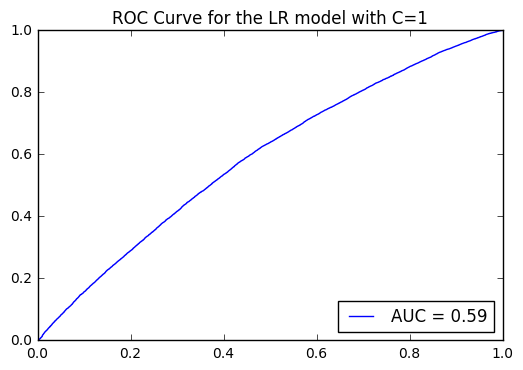

In [18]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model with C=1')
plt.legend(loc =4)
plt.show()

### 1.1.2 Principal Component Analysis before training Logistic Regression classifier (Pre-Processing)

In [19]:
pca = PCA(n_components=90)
SEED = 420
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
# Pick the top 90 components of PCA
XPCA_train = pca.fit_transform(X_train)
# Transform test set accordingly
XPCA_test = pca.transform(X_test)

In [20]:
C = [10000,100, 1, 0.01,0.0001]
in_score = []
out_score = []
for c in C:
    lr = linear_model.LogisticRegression(C=c)
    lr.fit(XPCA_train,y_train)
    in_score.append(lr.score(XPCA_train,y_train))
    out_score.append(lr.score(XPCA_test,y_test))

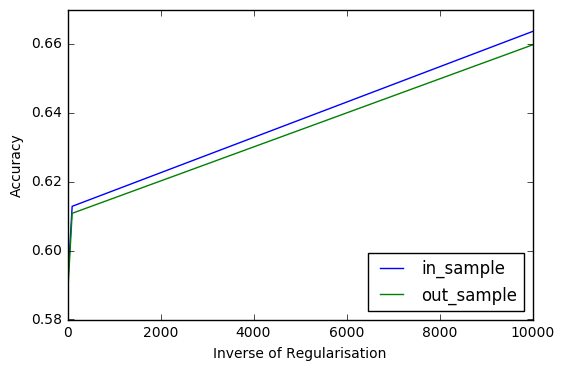

In [21]:
plt.plot(C,in_score, label='in_sample')  
plt.plot(C,out_score, label='out_sample')
plt.ylabel('Accuracy')
plt.xlabel('Inverse of Regularisation')
plt.legend(loc = 4)
plt.show()

In [22]:
print 'Highest out-sample accuracy', max(out_score), 'occurs for the model with C =', C[np.argmax(out_score)]

Highest out-sample accuracy 0.659721947162 occurs for the model with C = 10000


In [23]:
# For C > 10000 the accuracy seem to decrease again. Hence, it appears that C ~ 10000 is the most 'accurate' model

#### ROC Curve for the model with highest 'accuracy'

In [24]:
lr = linear_model.LogisticRegression(C=C[np.argmax(out_score)])

lr.fit(XPCA_train,y_train)
probs = lr.predict_proba(XPCA_test)[:,1] # get the probabilities of positive outcom

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

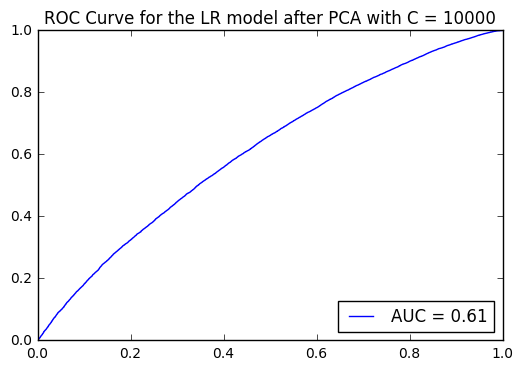

In [25]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model after PCA with C = %d' %C[np.argmax(out_score)])
plt.legend(loc =4)
plt.show()

### 1.1.3 Feature Selection Using Recursive Feature Extraction (post-processing)

In [26]:
SEED = 420
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Use the model parameter with the highest roc-auc score (1.1.1) to train a model
lrf = linear_model.LogisticRegression(C=C[np.argmax(cv_score)]) 
# Recursively select the top 90 features
selector = RFE(lrf, 90, step=20) 
selector = selector.fit(X_train, y_train) 

In [27]:
# Collect the top 90 features together
mask = selector.support_
top_features = X.columns[mask]
X_top = X[top_features]

In [28]:
# Train Logistic Regression clf and cross validate on the top features X_top
C = [10000,100, 1, 0.01,0.0001] 
cv_score = [] 
for c in C:
    lr = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(lr,X_top,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean()) 

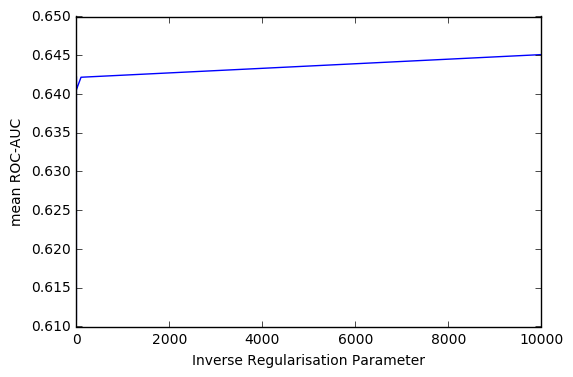

In [29]:
plt.plot(C,cv_score)
plt.ylabel('mean ROC-AUC')
plt.xlabel('Inverse Regularisation Parameter')
plt.show()

In [30]:
print 'Highest mean roc_auc of', max(cv_score), 'occurs for C = ', C[np.argmax(cv_score)]

Highest mean roc_auc of 0.64508474631 occurs for C =  10000


#### ROC Curve for the model with highest mean ROC_AUC

In [31]:
# Run Logistic regression on the top 90 features
lr_top = linear_model.LogisticRegression(C=C[np.argmax(cv_score)])
SEED = 42
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=SEED)
lr_top.fit(X_top_train,y_train)


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
probs = lr_top.predict_proba(X_top_test)[:,1] # get the probabilities of positive outcome
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

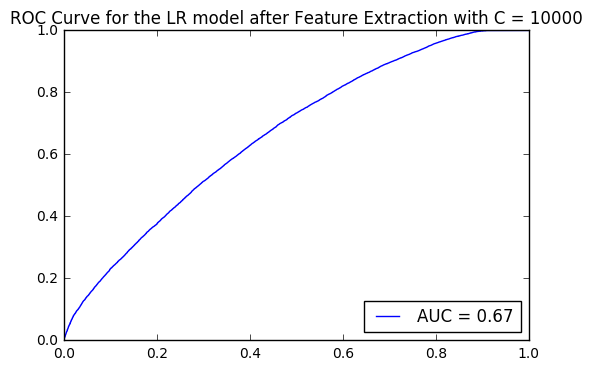

In [33]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model after Feature Extraction with C = %d' %C[np.argmax(cv_score)])
plt.legend(loc = 4)
plt.show()

## 1.2 Random Forest

### 1.2.1 K-fold cross validation against number of estimators using Random Forest classifier

In [34]:
# Try Random Forest classifier next and cross-validate
ks = [10,20,50,100]
cv_score = []
for k in ks:
    RF = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    scores = cross_val_score(RF,X,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

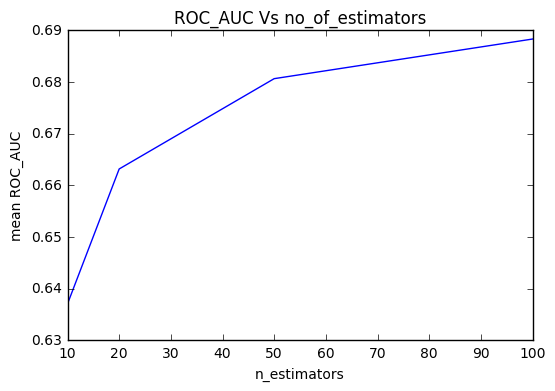

In [35]:
plt.plot(ks,cv_score)
plt.title('ROC_AUC Vs no_of_estimators')
plt.ylabel('mean ROC_AUC')
plt.xlabel('n_estimators')
plt.show()

In [36]:
print 'The highest mean roc_auc score of', max(cv_score), 'occurs for n_estimators =', ks[np.argmax(cv_score)]

The highest mean roc_auc score of 0.688320150001 occurs for n_estimators = 100


The curve increases with the number of trees used. However it seems to plateau for higher no of trees. Hence we have limited n_estimators to 100 considering the computational capacity.

#### ROC Curve for the model with highest mean ROC_AUC

In [37]:
RF = RandomForestClassifier(n_estimators= ks[np.argmax(cv_score)],oob_score=False, random_state=42)
SEED = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

res = RF.fit(X_train,y_train)
probs = res.predict_proba(X_test)[:,1] # get the probabilities of positive outcome

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

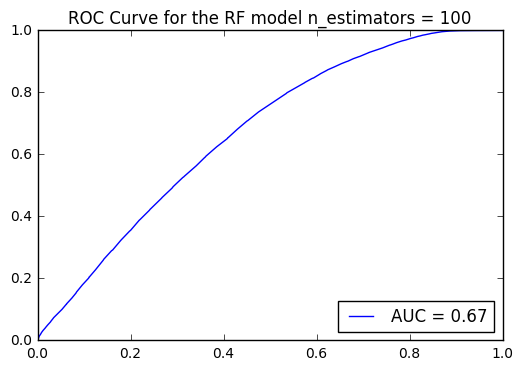

In [38]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model n_estimators = %d' %ks[np.argmax(cv_score)])
plt.legend(loc = 4)
plt.show()

### 1.2.2 Random Forest classifier after PCA analysis (pre-processing)

In [39]:
#Train RF clf on reduced data by PCA analysis (1.1.2)
ks = [10,20,50,100]
in_score = []
out_score = []
print 'running model k =',
for k in ks:
    print k,
    clf = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    res = clf.fit(XPCA_train, y_train)
    in_score.append(res.score(XPCA_train, y_train)) 
    out_score.append(res.score(XPCA_test, y_test))

running model k = 10 20 50 100


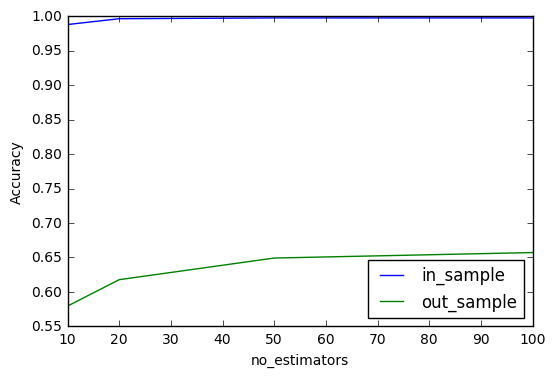

In [40]:
plt.plot(ks,in_score, label='in_sample')
plt.plot(ks,out_score, label='out_sample')
plt.ylabel('Accuracy')
plt.xlabel('no_estimators')
plt.legend(loc = 4)
plt.show()

In [41]:
print 'Highest accuracy score of', max(out_score), 'occurs for n_estimators =', ks[np.argmax(out_score)]

Highest accuracy score of 0.657127579514 occurs for n_estimators = 100


#### ROC Curve for the model with highest 'accuracy'

In [42]:
clf = RandomForestClassifier(n_estimators= ks[np.argmax(out_score)], oob_score=False, random_state=42)
res = clf.fit(XPCA_train, y_train)
probs = res.predict_proba(XPCA_test)[:,1] # get the probabilities of positive outcom
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

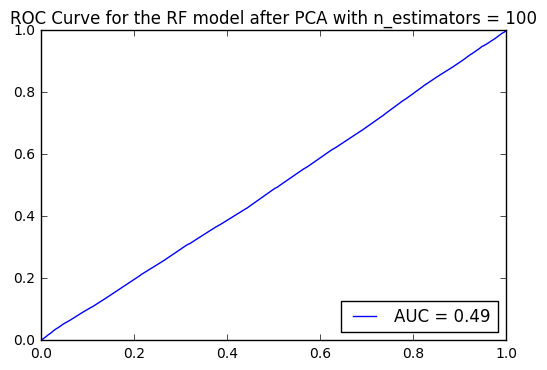

In [43]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model after PCA with n_estimators = %d' %ks[np.argmax(out_score)])
plt.legend(loc =4)
plt.show()

### 1.2.3 Feature Selection Using Feature importance in RF (Post-Processing)

In [44]:
#Use the model with the highest mean ROC_AUC (1.2.1) to identify the most important features
RF = RandomForestClassifier(n_estimators=100, oob_score=False, random_state=42)
RF = RF.fit(X_train, y_train)

In [45]:
#Collect the top 90 features
X_top = X.ix[:,RF.feature_importances_.argsort()[::-1][:90]]

In [46]:
#Run cross-validation on this reduced data set
ks = [10,20,50,100]
cv_score = []
print 'running model k=',
for k in ks:
    print k,
    RF = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    scores = cross_val_score(RF,X_top,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

running model k= 10 20 50 100


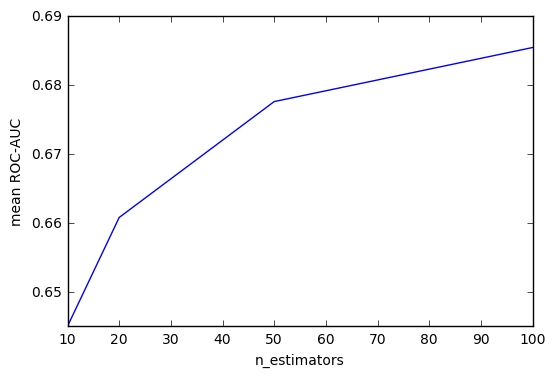

In [47]:
plt.plot(ks,cv_score)
plt.xlabel('n_estimators')
plt.ylabel('mean ROC-AUC')
plt.show()

In [48]:
print 'Highest mean roc_auc score of', max(cv_score), 'occurs for n_estimators =', ks[np.argmax(cv_score)]

Highest mean roc_auc score of 0.685474835058 occurs for n_estimators = 100


#### ROC Curve for the model with highest mean ROC_AUC

In [49]:
RF = RandomForestClassifier(n_estimators= ks[np.argmax(cv_score)],oob_score=False, random_state=42)
SEED = 32
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=SEED)

res = RF.fit(X_top_train,y_train)
probs = res.predict_proba(X_top_test)[:,1] # get the probabilities of positive outcome

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

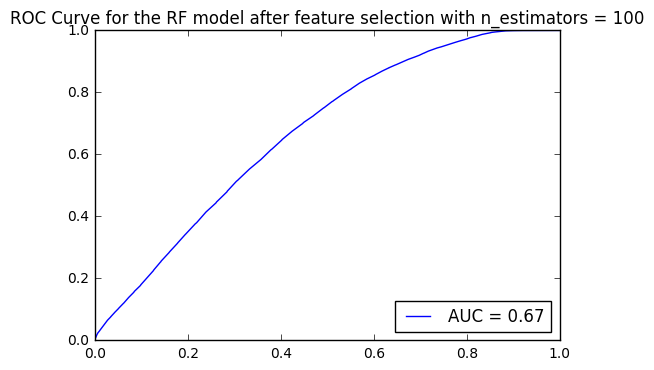

In [50]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model after feature selection with n_estimators = %d' %ks[np.argmax(out_score)])
plt.legend(loc = 4)
plt.show()

# 2. Data Scheme: Analysis with only Numeric Data

In [51]:
#Extract only numeric features
data_num = data_raw._get_numeric_data()

In [52]:
#Remove featurs that has more than 90% null data
data_num = data_num.loc[:,data_num.notnull().mean() > 0.1]

In [53]:
#Remaning null columns
col_null=data_num.columns[data_num.isnull().any()]
col_null

Index([u'ProsperScore', u'FracDebtToIncomeRatio', u'NumMonthsEmployed'], dtype='object')

In [54]:
# Fill columns containing null appropriately
data_num['ProsperScore'] = data_num['ProsperScore'].fillna(data_num['ProsperScore'].mean())
data_num['NumMonthsEmployed'] = data_num['NumMonthsEmployed'].fillna(data_num['NumMonthsEmployed'].mean())
data_num['FracDebtToIncomeRatio'] = data_num['FracDebtToIncomeRatio'].fillna(data_num['FracDebtToIncomeRatio'].mean())

In [55]:
data_num.shape

(252469, 62)

In [56]:
# Define numeric-only feature set X_num
X_num = data_num
del X_num['EnumListingStatus']

In [57]:
X_num.head().T

ListingNumber,973605,981099,1025766,1003835,1011335
ListingID,973605,981099,1025766,1003835,1011335
DolLoanAmountRequested,15000,15000,4000,10000,20000
BoolPartialFundingApproved,True,True,True,True,True
LenderYield,0.152,0.1485,0.1985,0.1199,0.134
BorrowerRate,0.162,0.1585,0.2085,0.1299,0.144
NumMonthsTerm,60,60,36,36,60
DolMonthlyLoanPayment,366.37,363.58,150.39,336.89,469.52
FICOScore,689,709,669,749,649
ProsperScore,6,8,6,5,11
EnumListingCategory,1,1,1,13,1


## 2.1 Logistic Regression

### 2.1.1 K-fold cross validation on numeric-only data set using Logistic Regression

In [58]:
# Logistic Regression
C = [10000,100, 1, 0.01,0.0001] # scores using Cross Validation
cv_score = []
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(lr,X_num,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

running model C = 10000 100 1 0.01 0.0001


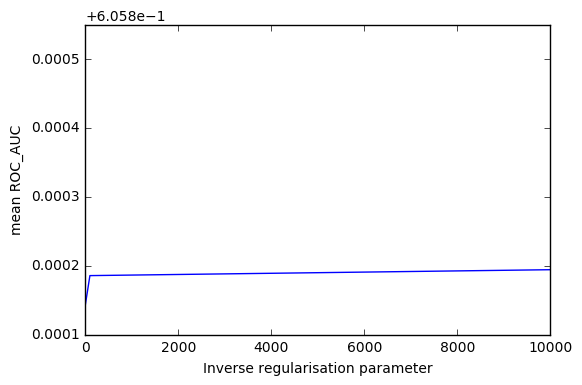

In [59]:
plt.plot(C,cv_score)
plt.xlabel('Inverse regularisation parameter')
plt.ylabel('mean ROC_AUC')
plt.show()

In [60]:
print 'The highest mean roc_auc score of', max(cv_score), 'occurs for C = ', C[np.argmax(cv_score)]

The highest mean roc_auc score of 0.606302542241 occurs for C =  0.01


The curve is almost flat across varying inverse parameters (C)

#### ROC Curve for the model with the highest mean ROC_AUC

In [61]:
lr = linear_model.LogisticRegression(C= C[np.argmax(cv_score)])
SEED = 32
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=SEED)

lr.fit(X_num_train,y_train)
probs = lr.predict_proba(X_num_test)[:,1] # get the probabilities of positive outcome

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

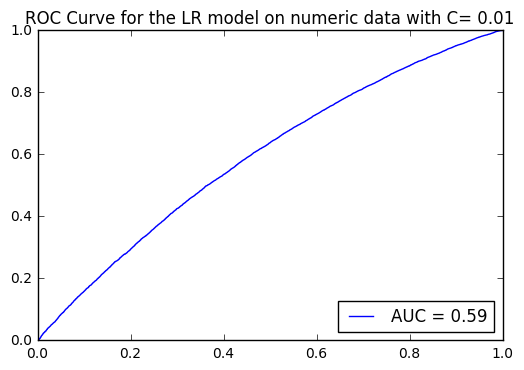

In [62]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model on numeric data with C= %0.2f' % C[np.argmax(cv_score)])
plt.legend(loc = 4)
plt.show()

### 2.1.2 Logistic Regression on numeric-only data after Principal Component Analysis (Pre-Processing)

In [63]:
X_num.shape

(252469, 61)

In [64]:
# collect the first 30 principal components 
pca = PCA(n_components=30)
SEED = 420
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=SEED)
X_num_PCA_train = pca.fit_transform(X_num_train)
X_num_PCA_test = pca.transform(X_num_test)

In [65]:
# Run models for different values of inverse regularisation parameter (C)
C = [10000,100, 1, 0.01,0.0001]
in_score = []
out_score = []
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C=c)
    lr.fit(X_num_PCA_train,y_train)
    in_score.append(lr.score(X_num_PCA_train,y_train))
    out_score.append(lr.score(X_num_PCA_test,y_test))

running model C = 10000 100 1 0.01 0.0001


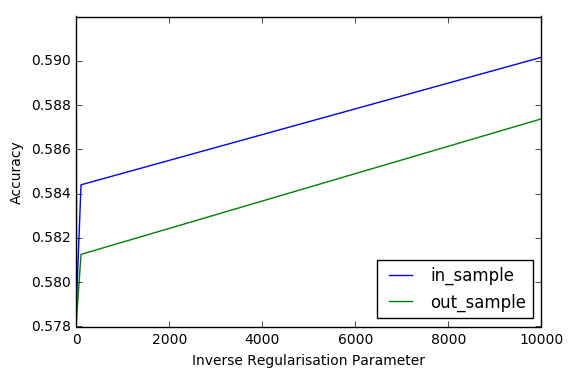

In [66]:
plt.plot(C,in_score,label = 'in_sample')
plt.plot(C,out_score,label = 'out_sample')
plt.xlabel('Inverse Regularisation Parameter')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [67]:
print 'Highest accuracy score of', max(out_score), 'occurs for C =', C[np.argmax(out_score)]

Highest accuracy score of 0.587376718026 occurs for C = 10000


The 'accuracy' increases with the inverse regularisation parameter or when the regularisation is reduced, however further tests yield that 'accuracy' plateaus and decreases after C ~ 10000

#### ROC Curve for model with highest 'accuracy' 

In [68]:
lr = linear_model.LogisticRegression(C= C[np.argmax(out_score)])
lr.fit(X_num_PCA_train,y_train)

probs = lr.predict_proba(X_num_PCA_test)[:,1] # get the probabilities of positive outcom

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

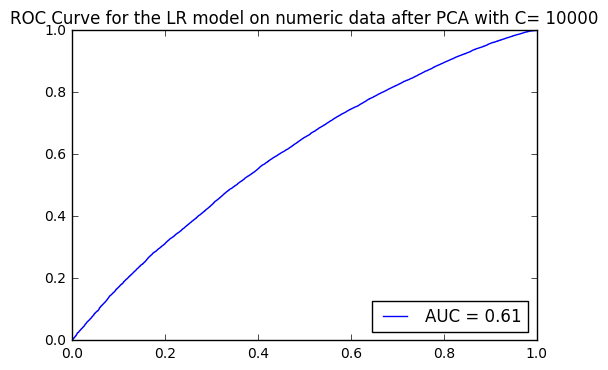

In [69]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model on numeric data after PCA with C= %d' % C[np.argmax(out_score)])
plt.legend(loc=4)
plt.show()

### 2.1.3 Recursive feature Extraction on numeric-only data-set using Logistic Regression

In [70]:
#Feature Selection using Recursive feature extraction (RFE) by training the model with the highest ROC_AUC (2.1.1)
# and collecting the top 30 features into X_num_top
from sklearn.feature_selection import RFE 

SEED = 420
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=SEED)

lrf = linear_model.LogisticRegression(C=C[np.argmax(cv_score)]) 
selector = RFE(lrf, 30, step=10) 
selector = selector.fit(X_num_train, y_train) 

mask = selector.support_
top_features = X_num.columns[mask]

X_num_top = X_num[top_features]

In [71]:
#Run Cross-Validation on this reduced data-set
C = [10000,100, 1, 0.01,0.0001] 
cv_score = []
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(lr,X_num_top,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

running model C = 10000 100 1 0.01 0.0001


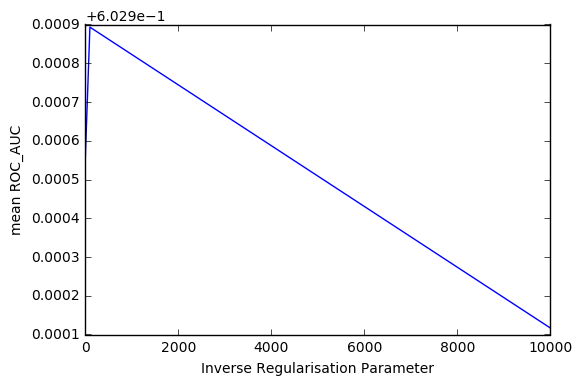

In [72]:
plt.plot(C,cv_score)
plt.xlabel('Inverse Regularisation Parameter')
plt.ylabel('mean ROC_AUC')
plt.show()

In [73]:
print 'Highest mean roc_auc of', max(cv_score), 'occurs at C =', C[np.argmax(cv_score)]

Highest mean roc_auc of 0.603793226584 occurs at C = 100


#### ROC Curve for the model with highest mean ROC-AUC

In [74]:
lr_top = linear_model.LogisticRegression(C=C[np.argmax(cv_score)])
SEED = 42
X_num_top_train, X_num_top_test, y_train, y_test = train_test_split(X_num_top, y, test_size=0.2, random_state=SEED)
lr_top.fit(X_num_top_train,y_train)
probs = lr_top.predict_proba(X_num_top_test)[:,1] # get the probabilities of positive outcom
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

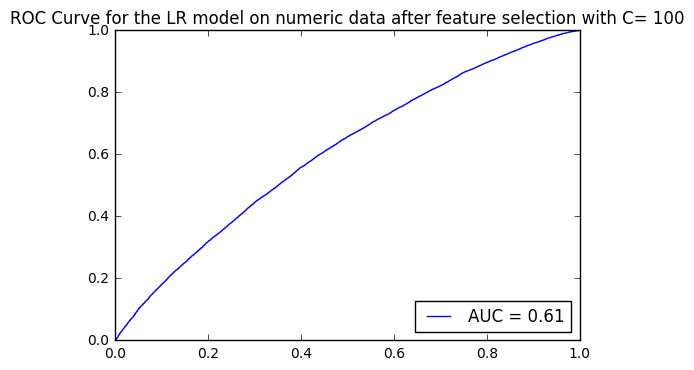

In [75]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the LR model on numeric data after feature selection with C= %d' % C[np.argmax(cv_score)])
plt.legend(loc=4)
plt.show()

## 2.2 Random Forest on numeric-only data-set

### 2.2.1 k-fold cross validation using RF on numeric-only data set

In [76]:
ks = [10,20,50,100]
cv_score = []
print 'running model n_estimators =',
for k in ks:
    print k,
    RF = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    scores = cross_val_score(RF,X_num,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

running model n_estimators = 10 20 50 100


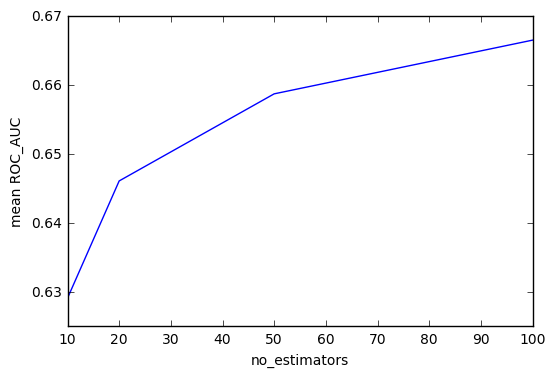

In [77]:
plt.plot(ks,cv_score)
plt.xlabel('no_estimators')
plt.ylabel('mean ROC_AUC')
plt.show()

In [78]:
print 'The Highest mean roc_auc score of', max(cv_score), 'occurs for n_estimators =', ks[np.argmax(cv_score)]

The Highest mean roc_auc score of 0.666546586462 occurs for n_estimators = 100


#### ROC Curve for the model with highest mean ROC_AUC

In [79]:
SEED = 320
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=SEED)
clf = RandomForestClassifier(n_estimators= ks[np.argmax(cv_score)], oob_score=False, random_state=42)
res = clf.fit(X_num_train, y_train)
probs = res.predict_proba(X_num_test)[:,1] # get the probabilities of positive outcom
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

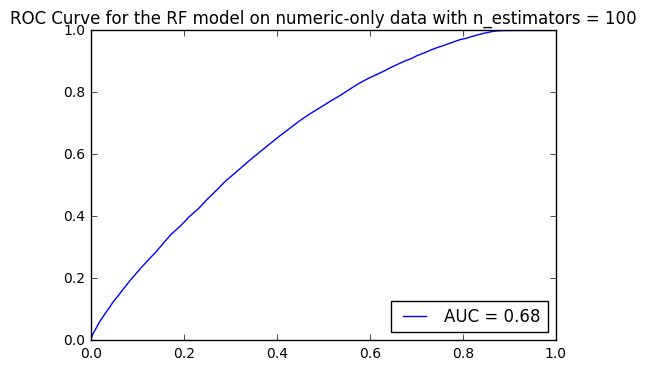

In [80]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model on numeric-only data with n_estimators = %d' %ks[np.argmax(cv_score)])
plt.legend(loc = 4)
plt.show()

### 2.2.2 Random Forest classifier on numeric-only data after PCA (post-processing)

In [81]:
# Train-Test split and PCA
SEED = 420
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=SEED)
X_num_PCA_train = pca.fit_transform(X_num_train)
X_num_PCA_test = pca.transform(X_num_test)

ks = [10,20,50,100]
score_in = []
score_out = []
print 'running model n_estimators =',
for k in ks:
    print k,
    clf = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    res = clf.fit(X_num_PCA_train, y_train)
    score_in += [res.score(X_num_PCA_train, y_train)]
    score_out += [res.score(X_num_PCA_test, y_test)]

running model n_estimators = 10 20 50 100


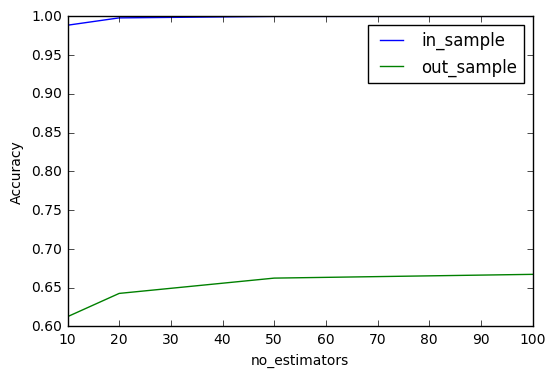

In [82]:
plt.plot(ks,score_in,label='in_sample')
plt.plot(ks,score_out,label = 'out_sample')
plt.xlabel('no_estimators')
plt.ylabel('Accuracy')
plt.legend(loc = 1)
plt.show()

In [83]:
print 'highest accuracy score of', max(score_out), 'occurs for n_estimators =', ks[np.argmax(score_out)]

highest accuracy score of 0.667108963441 occurs for n_estimators = 100


#### ROC Curve for the model with highest 'accuracy'

In [84]:
clf = RandomForestClassifier(n_estimators= ks[np.argmax(score_out)], oob_score=False, random_state=42)
res = clf.fit(X_num_PCA_train, y_train)
probs = res.predict_proba(X_num_PCA_test)[:,1] # get the probabilities of positive outcom
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

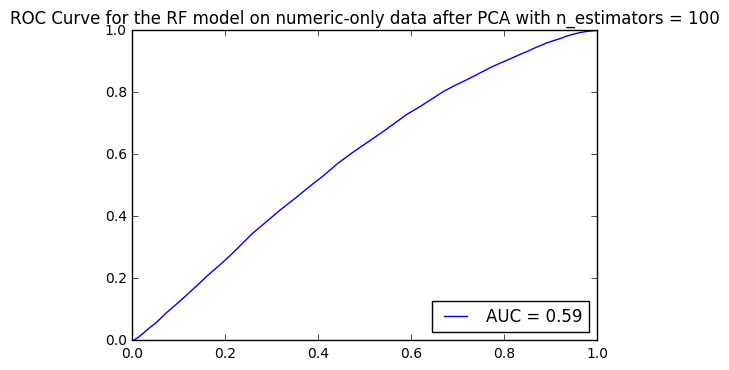

In [85]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model on numeric-only data after PCA with n_estimators = %d' %ks[np.argmax(score_out)])
plt.legend(loc =4)
plt.show()

### 2.2.3 Random Forest on numeric-only data after Feature Selection (post-processing)

In [86]:
# Collect the top 30 features after training RF using the model with the highest mean ROC_AUC (2.2.1) in X_num_top
RF = RandomForestClassifier(n_estimators=ks[np.argmax(cv_score)], oob_score=False, random_state=42)
RF = RF.fit(X_num_train, y_train)
X_num_top = X_num.ix[:,RF.feature_importances_.argsort()[::-1][:30]]

In [87]:
# Train and cross-validate on the top features
ks = [10,20,50,100]
cv_score = []
print 'running model n_estimators = ',
for k in ks:
    print k,
    RF = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    scores = cross_val_score(RF,X_num_top,y,cv = 5,scoring='roc_auc')
    cv_score.append(scores.mean())

running model n_estimators =  10 20 50 100


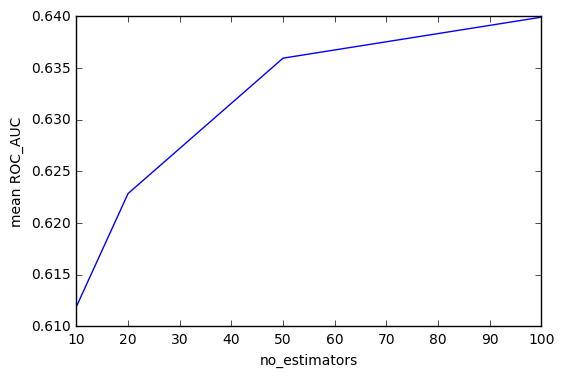

In [88]:
plt.plot(ks,cv_score)
plt.xlabel('no_estimators')
plt.ylabel('mean ROC_AUC')
plt.show()

In [89]:
print 'highest mean ROC_AUC of', max(cv_score), 'occurs for n_estimators =', ks[np.argmax(cv_score)]

highest mean ROC_AUC of 0.639919797934 occurs for n_estimators = 100


#### ROC Curve for the model with the highest mean ROC_AUC

In [90]:
SEED = 420
X_num_top_train, X_num_top_test, y_train, y_test = train_test_split(X_num_top, y, test_size=0.2, random_state=SEED)

In [91]:
RF = RandomForestClassifier(n_estimators=ks[np.argmax(cv_score)], oob_score=False, random_state=42)
RF = RF.fit(X_num_top_train, y_train)
probs = RF.predict_proba(X_num_top_test)[:,1] # get the probabilities of positive outcom
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

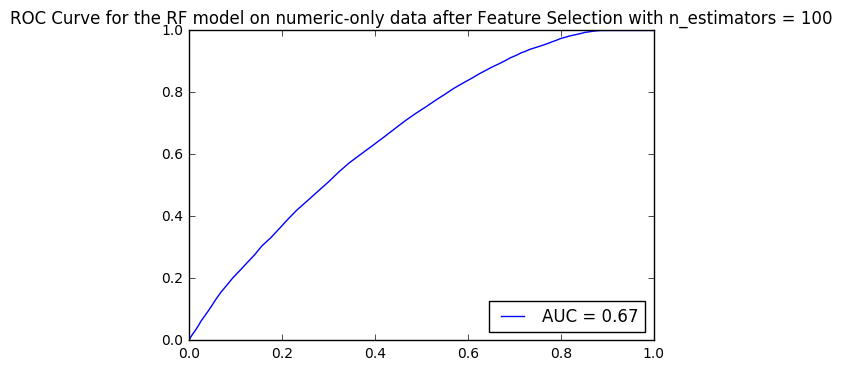

In [92]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC Curve for the RF model on numeric-only data after Feature Selection with n_estimators = %d' %ks[np.argmax(cv_score)])
plt.legend(loc = 4)
plt.show()

# 3. Data Scheme: Leave-One-Out Encoding (LOO)
Description: Leave-One-Out Encoding is a method for transforming categorical data into numerical data. Given a categorical record in the training set, LOO algorithm excludes the corresponding 'target'('y') value and finds the mean of 'y' values pertaining to that particular category in the training set. 
      
In the test set, the algorithm finds the mean of the 'y' values in the training set pertaining to that category.

In [93]:
data_loo = data_raw.copy()

In [94]:
#Remove all the date columns
data_loo = data_loo[[col for col in data_loo.columns if col[:4]!='Date']]

In [95]:
# Remove columns with more than 90% null data
data_loo = data_loo.loc[:,data_loo.notnull().mean()>0.1]

In [96]:
# Remaining columns with null data
data_loo.columns[data_loo.isnull().any()]

Index([u'ProsperScore', u'FracDebtToIncomeRatio', u'StrOccupation',
       u'NumMonthsEmployed'],
      dtype='object')

In [97]:
# Fill remaining columns with null data appropriately
data_loo['StrOccupation'] = data_loo['StrOccupation'].fillna('Other')
data_loo['ProsperScore'] = data_loo['ProsperScore'].fillna(data_loo['ProsperScore'].mean())
data_loo['NumMonthsEmployed'] = data_loo['NumMonthsEmployed'].fillna(data_loo['NumMonthsEmployed'].mean())
data_loo['FracDebtToIncomeRatio'] = data_loo['FracDebtToIncomeRatio'].fillna(data_loo['FracDebtToIncomeRatio'].mean())

In [98]:
# Any string after '-' or '(' in 'StrOccupation' is removed
data_loo['StrOccupation'] = data_loo['StrOccupation'].apply(lambda x : x.split('-')[0].split('(')[0])
# Make every thing in 'StrBorrowerCity' upper-case
data_loo['StrBorrowerCity'] = data_loo['StrBorrowerCity'].apply(lambda x : x.upper())

In [99]:
data_loo.head().T

ListingNumber,973605,981099,1025766,1003835,1011335
ListingID,973605,981099,1025766,1003835,1011335
EnumListingStatus,7,7,6,7,6
DolLoanAmountRequested,15000,15000,4000,10000,20000
BoolPartialFundingApproved,True,True,True,True,True
CreditGrade,B,B,D,A,B
LenderYield,0.152,0.1485,0.1985,0.1199,0.134
BorrowerRate,0.162,0.1585,0.2085,0.1299,0.144
NumMonthsTerm,60,60,36,36,60
DolMonthlyLoanPayment,366.37,363.58,150.39,336.89,469.52
FICOScore,689,709,669,749,649


In [100]:
# Categorical Variables 
data_loo.columns[data_loo.dtypes == 'object']

Index([u'CreditGrade', u'StrEmploymentStatus', u'StrOccupation', u'StrState',
       u'StrBorrowerCity', u'EnumChannelCode'],
      dtype='object')

In [101]:
#Rename the target 
data_loo['y'] = data_loo['EnumListingStatus'] == 6

In [102]:
del data_loo['EnumListingStatus']

In [103]:
# Split the data into training and test set for Leave-One-Out encoding
SEED = 420
data_loo_train, data_loo_test = train_test_split(data_loo, test_size=0.2, random_state=SEED)

In [104]:
#Convert Categorical features into numerical via leave-one-out mechanism in the training set
data_loo_train['CreditGrade_mean'] = data_loo_train.groupby('CreditGrade')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))
data_loo_train['StrEmploymentStatus_mean'] = data_loo_train.groupby('StrEmploymentStatus')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))
data_loo_train['StrOccupation_mean'] = data_loo_train.groupby('StrOccupation')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))
data_loo_train['StrState_mean'] = data_loo_train.groupby('StrState')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))
data_loo_train['StrBorrowerCity_mean'] = data_loo_train.groupby('StrBorrowerCity')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))
data_loo_train['EnumChannelCode_mean'] = data_loo_train.groupby('EnumChannelCode')['y'].transform(lambda x: (x.sum()-x) /(x.size-1))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [105]:
# Treat test data (convert categorical features into numerical) via LOO mechanism 
lc =data_loo_train.groupby(by='CreditGrade')['y'].mean()
data_loo_test['CreditGrade_mean'] = data_loo_test['CreditGrade'].apply(lambda x:lc[x] if x in lc else 0  )

se=data_loo_train.groupby(by='StrEmploymentStatus')['y'].mean()
data_loo_test['StrEmploymentStatus_mean']= data_loo_test['StrEmploymentStatus'].apply(lambda x: se[x] if x in se else 0 )

so=data_loo_train.groupby(by='StrOccupation')['y'].mean()
data_loo_test['StrOccupation_mean']= data_loo_test['StrOccupation'].apply(lambda x: so[x] if x in so else 0 )

ss=data_loo_train.groupby(by='StrState')['y'].mean()
data_loo_test['StrState_mean']= data_loo_test['StrState'].apply(lambda x:ss[x] if x in ss else 0)

sb = data_loo_train.groupby(by='StrBorrowerCity')['y'].mean()
data_loo_test['StrBorrowerCity_mean']= data_loo_test['StrBorrowerCity'].apply(lambda x: sb[x] if x in sb else 0)

ec=data_loo_train.groupby(by='EnumChannelCode')['y'].mean()
data_loo_test['EnumChannelCode_mean']= data_loo_test['EnumChannelCode'].apply(lambda x: ec[x] if x in ec else 0)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [106]:
# Delete previous categorical data in the training-set
del data_loo_train['CreditGrade']
del data_loo_train['StrEmploymentStatus']
del data_loo_train['StrOccupation']
del data_loo_train['StrState']
del data_loo_train['StrBorrowerCity']
del data_loo_train['EnumChannelCode']

In [107]:
# Delete previous categorical data in the test-set
del data_loo_test['CreditGrade']
del data_loo_test['StrEmploymentStatus']
del data_loo_test['StrOccupation']
del data_loo_test['StrState']
del data_loo_test['StrBorrowerCity']
del data_loo_test['EnumChannelCode']

In [108]:
#Feature Target Seperation
y_train = data_loo_train['y']
y_test = data_loo_test['y']
del data_loo_train['y']
del data_loo_test['y']

In [109]:
X_loo_train = data_loo_train
X_loo_test = data_loo_test

## 3.1 Logistic Regression with Leave-One-Out encoding

### 3.1.1 Logistic regression classifier trained against inverse regularisation parameter

In [110]:
C = [10000,100,1,0.01,0.0001]
in_score = []
out_score =[]
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C=c)
    lr.fit(X_loo_train,y_train)
    in_score.append(lr.score(X_loo_train,y_train))
    out_score.append(lr.score(X_loo_test,y_test))

running model C = 10000 100 1 0.01 0.0001


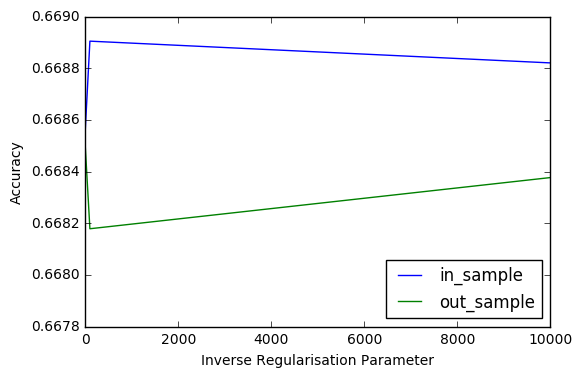

In [111]:
plt.plot(C,in_score,label = 'in_sample')
plt.plot(C,out_score,label = 'out_sample')
plt.xlabel('Inverse Regularisation Parameter')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [112]:
print 'Highest accuracy score of', max(out_score), 'occurs at C =', C[np.argmax(out_score)]

Highest accuracy score of 0.668495266764 occurs at C = 1


Accuracy seems to flatten and then decrease for C > 10000 according to further tests

#### ROC Curve for the model with the highest 'accuracy'

In [113]:
lr = linear_model.LogisticRegression(C=C[np.argmax(out_score)])
lr.fit(X_loo_train,y_train)

probs = lr.predict_proba(X_loo_test)[:,1] # get the probabilities of positive outcome
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

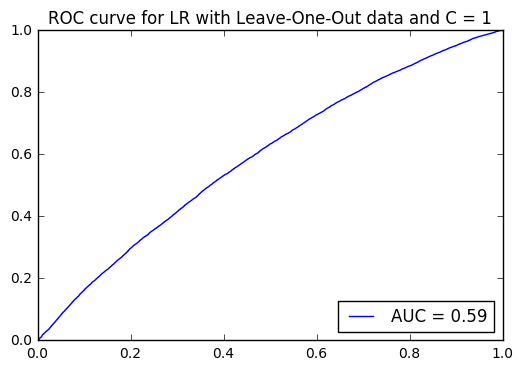

In [114]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for LR with Leave-One-Out data and C = %d' %C[np.argmax(out_score)])
plt.legend(loc = 4)
plt.show()

### 3.1.2 Logistic Regression after PCA analysis (pre-processing)

In [115]:
pca = PCA(n_components=30)
X_loo_PCA_train = pca.fit_transform(X_loo_train)
X_loo_PCA_test = pca.transform(X_loo_test)

In [116]:
C = [10000,100,1,0.01,0.0001]
in_score = []
out_score = []
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C = c)
    lr.fit(X_loo_PCA_train,y_train)
    in_score.append(lr.score(X_loo_PCA_train,y_train))
    out_score.append(lr.score(X_loo_PCA_test,y_test))

running model C = 10000 100 1 0.01 0.0001


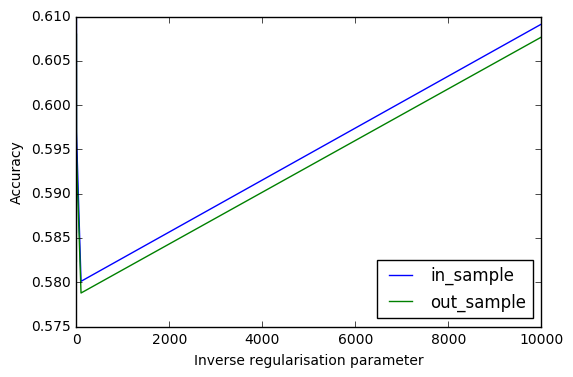

In [117]:
plt.plot(C,in_score,label = 'in_sample')
plt.plot(C,out_score,label = 'out_sample')
plt.xlabel('Inverse regularisation parameter')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [118]:
print 'Highest accuracy score of', max(out_score), 'occurs for C =', C[np.argmax(out_score)]

Highest accuracy score of 0.608072246207 occurs for C = 0.01


#### ROC Curve for the model with the highest 'accuracy'

In [119]:
#lr = linear_model.LogisticRegression(C = C[np.argmax(out_score)])
#lr.fit(X_loo_PCA_train,y_train)
probs = lr.predict_proba(X_loo_PCA_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

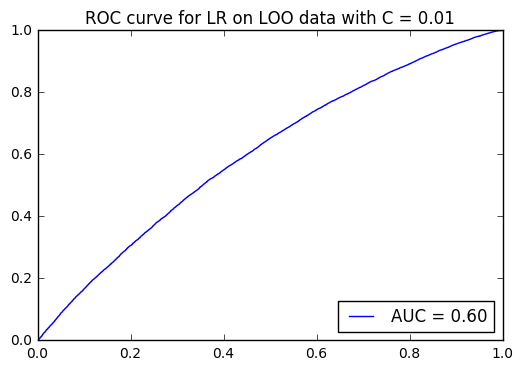

In [120]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for LR on LOO data with C = %0.2f' %C[np.argmax(out_score)])
plt.legend(loc = 4)
plt.show()

### 3.1.3 Logistic Regression with Recursive Feature Extraction (Post-processing) on LOO data

In [121]:
lrf = linear_model.LogisticRegression(C=C[np.argmax(out_score)]) 
selector = RFE(lrf, 30, step=10) 
selector = selector.fit(X_loo_train, y_train) 

mask = selector.support_
top_features = X_loo_train.columns[mask]

X_loo_top_train = X_loo_train[top_features]
X_loo_top_test  = X_loo_test[top_features]

In [122]:
# Train Logistic Regression on the reduced data-set
C=[10000,100,1,0.01,0.0001]
in_score = []
out_score =[]
print 'running model C =',
for c in C:
    print c,
    lr = linear_model.LogisticRegression(C = c)
    lr.fit(X_loo_top_train,y_train)
    in_score.append(lr.score(X_loo_top_train,y_train))
    out_score.append(lr.score(X_loo_top_test,y_test))

running model C = 10000 100 1 0.01 0.0001


In [123]:
print 'Highest accuracy score of', max(out_score), 'occurs for C =', C[np.argmax(out_score)]

Highest accuracy score of 0.667861528102 occurs for C = 0.0001


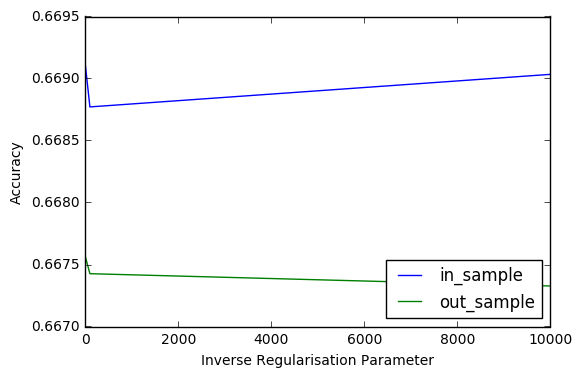

In [124]:
plt.plot(C,in_score,label = 'in_sample')
plt.plot(C,out_score,label = 'out_sample')
plt.xlabel('Inverse Regularisation Parameter')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

#### ROC Curve for the model with highest 'accuracy'

In [125]:
lr = linear_model.LogisticRegression(C = C[np.argmax(out_score)])
lr.fit(X_loo_top_train, y_train)
probs = lr.predict_proba(X_loo_top_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

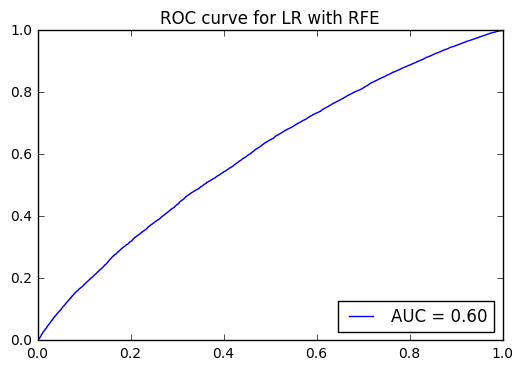

In [126]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for LR with RFE')
plt.legend(loc = 4)
plt.show()

## 3.2 Random Forest Classifier with LOO data

### 3.2.1 Training RF with LOO data for varying number of trees in the forest

In [127]:
ks = [10,20,50,100]
in_score = []
out_score = []
print 'running model n_estimators =',
for k in ks:
    print k,
    clf = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    res = clf.fit(X_loo_train,y_train)
    in_score.append(res.score(X_loo_train,y_train))
    out_score.append(res.score(X_loo_test,y_test))

running model n_estimators = 10 20 50 100


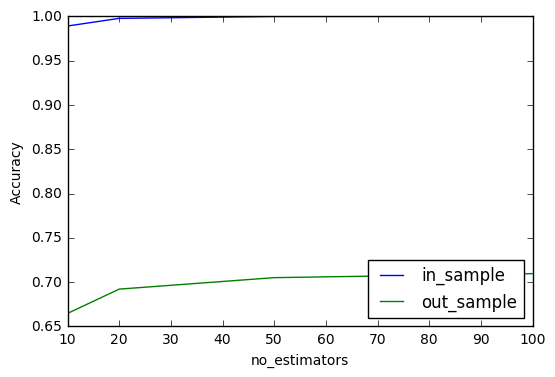

In [128]:
plt.plot(ks,in_score,label = 'in_sample')
plt.plot(ks, out_score, label = 'out_sample')
plt.xlabel('no_estimators')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [129]:
print 'Highest accuracy score of', max(out_score), 'occurs for n_estimators = ', ks[np.argmax(out_score)]

Highest accuracy score of 0.70952984513 occurs for n_estimators =  100


#### ROC Curve for the model with the highest 'accuracy'

In [130]:
clf = RandomForestClassifier(n_estimators=ks[np.argmax(out_score)],oob_score=False, random_state=42)
res = clf.fit(X_loo_train,y_train)
probs = res.predict_proba(X_loo_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

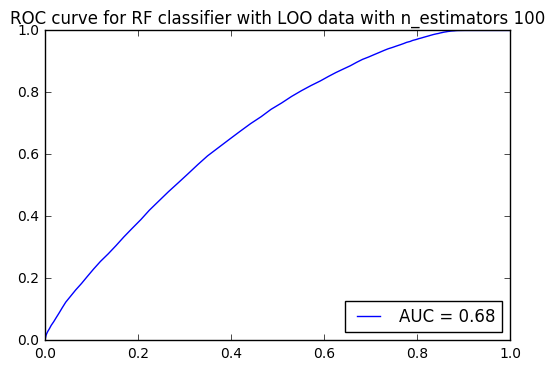

In [131]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for RF classifier with LOO data with n_estimators %d' %ks[np.argmax(out_score)])
plt.legend(loc = 4)
plt.show()

### 3.2.2 Random Forest Classifier after PCA on LOO data (pre-processing)

In [132]:
ks = [10,20,50,100]
in_score = []
out_score = []
print 'running model n_estimators=',
for k in ks:
    print k,
    clf = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    res = clf.fit(X_loo_PCA_train,y_train)
    in_score.append(res.score(X_loo_PCA_train,y_train))
    out_score.append(res.score(X_loo_PCA_test,y_test))

running model n_estimators= 10 20 50 100


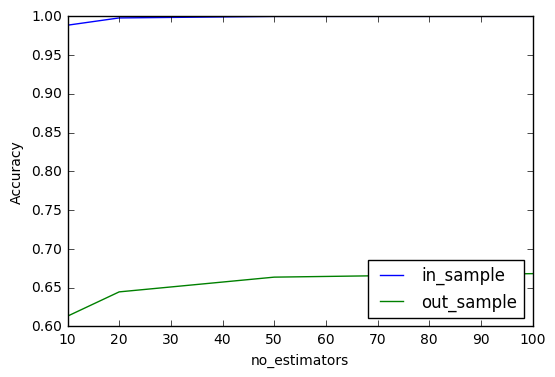

In [133]:
plt.plot(ks,in_score,label = 'in_sample')
plt.plot(ks,out_score,label = 'out_sample')
plt.xlabel('no_estimators')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [134]:
print 'Highest accuracy score of', max(out_score), 'occurs for n_estimators = ', ks[np.argmax(out_score)]

Highest accuracy score of 0.668019962768 occurs for n_estimators =  100


#### ROC Curve for the model with highest 'accuracy'

In [135]:
clf = RandomForestClassifier(n_estimators=ks[np.argmax(out_score)],oob_score=False, random_state=42)
res = clf.fit(X_loo_PCA_train,y_train)

In [136]:
probs = res.predict_proba(X_loo_PCA_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

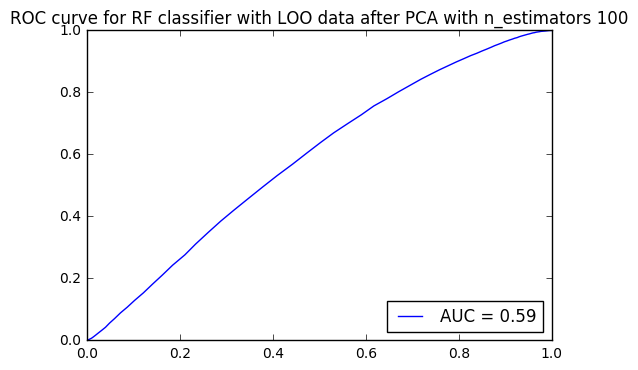

In [137]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for RF classifier with LOO data after PCA with n_estimators %d' %ks[np.argmax(out_score)])
plt.legend(loc = 4)
plt.show()

### 3.2.3 Random Forest Classifier with Feature Selection on LOO data (post-processing)

In [138]:
# Collect the top 30 features after training RF model with highest accuracy 3.2.1
RF = RandomForestClassifier(n_estimators=100, oob_score=False, random_state=42)
RF = RF.fit(X_loo_train, y_train)

X_loo_top_train = X_loo_train.ix[:,RF.feature_importances_.argsort()[::-1][:30]]
X_loo_top_test = X_loo_test.ix[:,RF.feature_importances_.argsort()[::-1][:30]]

In [139]:
# Train RF for reduced data set for varying no of trees in the forest
ks = [10,20,50,100]
in_score = []
out_score = []
print 'running model n_estimators=',
for k in ks:
    print k,
    clf = RandomForestClassifier(n_estimators=k, oob_score=False, random_state=42)
    res = clf.fit(X_loo_top_train,y_train)
    in_score.append(res.score(X_loo_top_train,y_train))
    out_score.append(res.score(X_loo_top_test,y_test))

running model n_estimators= 10 20 50 100


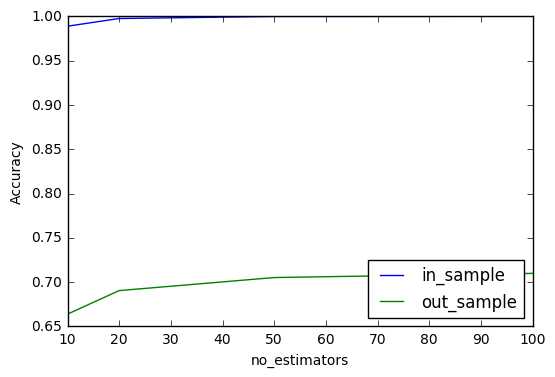

In [140]:
plt.plot(ks,in_score,label = 'in_sample')
plt.plot(ks,out_score,label = 'out_sample')
plt.xlabel('no_estimators')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

In [141]:
print 'Highest accuracy score of', max(out_score), 'occurs for n_estimators =', ks[np.argmax(out_score)]

Highest accuracy score of 0.709807105795 occurs for n_estimators = 100


#### ROC Curve for the model with the highest 'accuracy'

In [142]:
clf = RandomForestClassifier(n_estimators=ks[np.argmax(out_score)], oob_score=False, random_state=42)
res = clf.fit(X_loo_top_train,y_train)
probs = res.predict_proba(X_loo_top_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

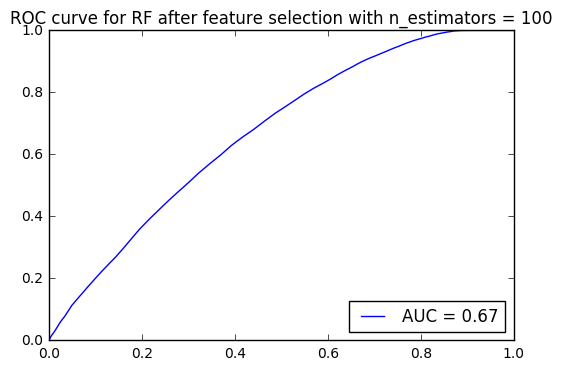

In [143]:
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.title('ROC curve for RF after feature selection with n_estimators = %d' %ks[np.argmax(out_score)])
plt.legend(loc=4)
plt.show()

# Conclusion and Observations

The investigation was conducted on three different data schemes to encode categorical data, they are

    1) One-Hot-Encoding: Encode categorical data by means of creating dummy variables for each category,i.e, 1 if it is present and 0 otherwise.
    
    2) Numeric-Only: Here the entire categorical features are just ignored
    
    3) Leave-One-Out Encoding: This method replaces an instance of a categorical record in the training set by taking the mean of all the remaining 'y' values corresponding to this particular category in the training-set, but excluding itself. Subsequently, the categorical features in the test-set are simply replaced by the mean 'y' value in the training-set pertaining to this category. This scheme does not generate additional columns/features as in One-Hot-Encoding.
    
    
    
For each of these data schemes, both Logistic Regression and Random Forest Classifiers were used. Each classifier was further subdivided by training them on 1) the entire data scheme 2) Reduced data-set after PCA (pre-processing) 3) Reduced data-set after selecting the most important featurs (post-processing).

The ROC-AUC and accuracy scores do not seem to be statistically significant across these models. In particular One-Hot-Encoding seems to give results that are very similar to the Numeric-Only data scheme. This suggests that dummifying the categorical variables lessens their predictive power, due to sparsity. One could detect a slight performance enhancement in the models under the data scheme of Leave-One-Out Encoding.